### Loading all the required packages

In [9]:
import os
import pandas as pd
import glob
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.utils.data as data
from qxr_utils.image.transforms import scale, resize
from qxr_utils.dicom.utils import get_array_from_dicom

import cv2
import matplotlib.pyplot as plt

import re
import numpy as np

In [10]:
root_path = "/data_nas5/models/user_checkpoints/anshul.singh/annotations/fda_study_2023/nva_fda/data/all_batches_pngs/all_frontal_pngs"

### Loading the data

In [3]:
inclusive_images = glob.glob(root_path+"/*.png")
len(inclusive_images)

3019

### Creating the dataset

In [14]:
class flipdset(data.Dataset):
    def __init__(self, filepaths):
        self.filepaths = filepaths

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        ext = os.path.splitext(filepath)[1]
        if ext in ['.jpg', '.png', '.jpeg']:
            img = cv2.imread(filepath, 0)
        elif ext in ['.dcm', '.dicom', '.dic']:
            img = get_array_from_dicom(filepath)
        org_shape = img.shape
        img = scale(img)

        flip_inp = resize(320, 320)(img)
        # zoom_inp = resize(512, 512)(img)

        return {"filepath": filepath,
                "flip_inp": torch.tensor(flip_inp, dtype=torch.float32).unsqueeze(0),
                "org_shape": str(org_shape)
                # "zoom_inp": torch.tensor(zoom_inp, dtype=torch.float32).unsqueeze(0)
               }


class zoomdset(data.Dataset):
    def __init__(self, filepaths):
        self.filepaths = filepaths

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        ext = os.path.splitext(filepath)[1]
        if ext in ['.jpg', '.png', '.jpeg']:
            img = cv2.imread(filepath, 0)
        elif ext in ['.dcm', '.dicom', '.dic']:
            img = get_array_from_dicom(filepath)
        org_shape = img.shape
        img = scale(img)

        # flip_inp = resize(320, 320)(img)
        zoom_inp = resize(512, 512)(img)

        return {"filepath": filepath,
                # "flip_inp": torch.tensor(flip_inp, dtype=torch.float32).unsqueeze(0),
                "zoom_inp": torch.tensor(zoom_inp, dtype=torch.float32).unsqueeze(0),
                # "org_shape": 
               }

In [15]:
inclusive_images = ['/data_nas5/models/user_checkpoints/anshul.singh/rtr/dopasi_issue/20826638-860476c2-343b951f-ca11f550-b4227243.dcm']
flipdataset = flipdset(inclusive_images)
zoomdataset = zoomdset(inclusive_images)

In [16]:
fliploader = data.DataLoader(
        flipdataset,
        batch_size=32,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
        shuffle=False,
        prefetch_factor=2,
    )
zoomloader = data.DataLoader(
        zoomdataset,
        batch_size=32,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
        shuffle=False,
        prefetch_factor=2,
    )

### Loading the model

In [17]:
flip_path = "/data_nas5/models/user_checkpoints/anshul.singh/repos/qureai/packages/python/qxr/traces_ts/v4_fliprot_cuda.ts"
# Wrap the TorchScript model
model = torch.jit.load(flip_path)

# Move the wrapped model to GPU
model = model.cuda()
model = nn.DataParallel(model, device_ids=[0])
model.eval()

DataParallel(
  (module): RecursiveScriptModule(
    original_name=export_to_pt
    (master): RecursiveScriptModule(
      original_name=ModuleList
      (0): RecursiveScriptModule(
        original_name=MultiHead
        (main_arch): RecursiveScriptModule(
          original_name=FPN
          (encoder): RecursiveScriptModule(
            original_name=EfficientNetEncoder
            (_conv_stem): RecursiveScriptModule(
              original_name=Conv2dStaticSamePadding
              (static_padding): RecursiveScriptModule(original_name=ZeroPad2d)
            )
            (_bn0): RecursiveScriptModule(original_name=BatchNorm2d)
            (_blocks): RecursiveScriptModule(
              original_name=ModuleList
              (0): RecursiveScriptModule(
                original_name=MBConvBlock
                (_depthwise_conv): RecursiveScriptModule(
                  original_name=Conv2dStaticSamePadding
                  (static_padding): RecursiveScriptModule(original_name=ZeroPa

In [21]:
with torch.no_grad():
    temp = model(flipdataset[0]['flip_inp'].unsqueeze(0).repeat(2,1,1,1).cuda())

In [22]:
temp

({'90_rot': tensor([5.3635e-06, 5.3635e-06], device='cuda:0'),
  '180_rot': tensor([1.2705e-19, 1.2705e-19], device='cuda:0'),
  'flipped': tensor([0.0004, 0.0004], device='cuda:0'),
  'unchanged': tensor([1.0000, 1.0000], device='cuda:0'),
  '270_rot': tensor([5.1607e-16, 5.1607e-16], device='cuda:0')},)

In [19]:
# out = [fliprot_dict['unchanged'][ct.GeneralKeys.cls],fliprot_dict['90_rot'][ct.GeneralKeys.cls],fliprot_dict['180_rot'][ct.GeneralKeys.cls],fliprot_dict['270_rot'][ct.GeneralKeys.cls],fliprot_dict['flipped'][ct.GeneralKeys.cls]]
# rot = (np.array(out[:4])).tolist()

flipper_th = 0.5
# flip = bool((np.array(out[4]) > flipper_th) * 1)
# rangle = rot.index(max(rot)) * 90

In [22]:
flip_dict = {}

with torch.no_grad():
    for batch in tqdm(fliploader):
        fnames = batch['filepath']
        outputs = model(batch["flip_inp"].cuda())[0]
        shapes = batch['org_shape']
        
        for j in range(len(fnames)):
            flip_dict[fnames[j]] = {tag: outputs[tag][j].cpu().item() for tag in outputs}
            
            rot = [flip_dict[fnames[j]][tag] for tag in ['unchanged', '90_rot', '180_rot', '270_rot']]
            rangle = rot.index(max(rot)) * 90
            
            flip_dict[fnames[j]].update({'flipped_prediction': flip_dict[fnames[j]]['flipped']>flipper_th, 'rot_angle': rangle})
            flip_dict[fnames[j]].update({'org_shape': shapes[j]})

100%|█████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:53<00:00,  1.77it/s]


In [23]:
new_df = pd.DataFrame(flip_dict).transpose()

In [27]:
new_df.to_csv("./filprot_preds_NvA_3019.csv", index=True)

### Run zoom model

In [23]:
import onnxruntime as ort
import numpy as np

zoom_path = "/data_nas5/models/user_checkpoints/anshul.singh/repos/qureai/packages/python/qxr/traces_ts/chest_zoom.onyx"
session = ort.InferenceSession(zoom_path)

In [24]:
zoom_dict = {}

with torch.no_grad():
    for idx in tqdm(range(len(zoomdataset))):
        input_data = zoomdataset[idx]
        fname = input_data['filepath']
        input_ = input_data["zoom_inp"].unsqueeze(0).numpy()
        
        outputs = session.run(None, {'input': input_})
        
        zoom_dict[fname] = {'zoom_coords': outputs[0]}

100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


In [25]:
zoom_df = pd.DataFrame(zoom_dict).transpose()

In [26]:
zoom_df

,zoom_coords
/data_nas5/models/user_checkpoints/anshul.singh/rtr/dopasi_issue/20826638-860476c2-343b951f-ca11f550-b4227243.dcm,"[[[65.84052, 42.769844, 471.2777, 433.85132]]]"


In [37]:
h1, w1, h2, w2 = 65.84052, 42.769844, 471.2777, 433.85132
h1_s = int(h1*2540/512)
h2_s = int(h2*2540/512)

w1_s = int(w1*3052/512)
w2_s = int(w2*3052/512)

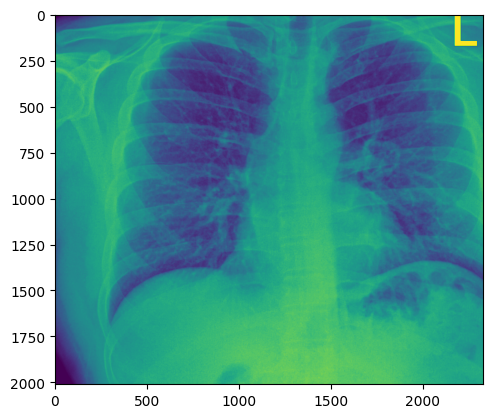

In [40]:
plt.imshow(img[h1_s:h2_s, w1_s:w2_s])

In [29]:
img = get_array_from_dicom(inclusive_images[0])

In [32]:
img[int(h1_s):int(h2_s), int(w1_s):int(w2_s)]

array([], shape=(0, 0), dtype=uint16)

In [33]:
h1_s

326.6307046875

In [34]:
h2_s

212.17852296875

In [ ]:
(65.84/512)

In [59]:
zoom_df.to_csv("./zoom_preds_NvA_3019.csv", index=True)

In [30]:
zoom_df = pd.read_csv("./zoom_preds_NvA_3019.csv", index_col=0)

In [31]:
zoom_df

,zoom_coords
/data_nas5/models/user_checkpoints/anshul.singh/annotations/fda_study_2023/nva_fda/data/all_batches_pngs/all_frontal_pngs/sF634E0CC-1.2.840.113564.10001.2022122705333151883.1012162.png,[[[ 36.6907 49.080467 448.08655 418.63248 ]]]
/data_nas5/models/user_checkpoints/anshul.singh/annotations/fda_study_2023/nva_fda/data/all_batches_pngs/all_frontal_pngs/1.3.6.1.4.1.55648.139280515811081756397220880572214434276.1001.1001.green.png,[[[ 39.239414 18.431738 509.6677 458.07272 ]]]
/data_nas5/models/user_checkpoints/anshul.singh/annotations/fda_study_2023/nva_fda/data/all_batches_pngs/all_frontal_pngs/s8CE0771B-1.2.840.113619.2.369.4.2147483647.1670865321.991671.1.png,[[[ 49.753376 49.936775 447.98257 499.2485 ]]]
/data_nas5/models/user_checkpoints/anshul.singh/annotations/fda_study_2023/nva_fda/data/all_batches_pngs/all_frontal_pngs/1.3.6.1.4.1.55648.079841418451713558050421652249195.1.1.green.png,[[[ 41.803143 13.997109 500.13147 420.8316 ]]]
/data_nas5/models/user_checkpoints/anshul.singh/annotations/fda_study_2023/nva_fda/data/all_batches_pngs/all_frontal_pngs/1.3.6.1.4.1.55648.232710112551477650948630721700248058680.1.2.green.png,[[[ 16.271582 24.794804 495.51804 421.7527 ]]]
...,...
/data_nas5/models/user_checkpoints/anshul.singh/annotations/fda_study_2023/nva_fda/data/all_batches_pngs/all_frontal_pngs/s39FEF19B-1.2.392.200036.9125.9.0.2149840738.100696064.2769779799.png,[[[ 32.504333 67.25357 511.79013 480.24826 ...
/data_nas5/models/user_checkpoints/anshul.singh/annotations/fda_study_2023/nva_fda/data/all_batches_pngs/all_frontal_pngs/s8C95154D-1.3.6.1.4.1.11157.19262186102197134.1672177864.446809.png,[[[106.50224 17.696953 512. 459.58273 ...
/data_nas5/models/user_checkpoints/anshul.singh/annotations/fda_study_2023/nva_fda/data/all_batches_pngs/all_frontal_pngs/sDC8BC5F7-1.2.410.200049.2.48609084159297.3.1.20221225201234280.72290.png,[[[ 32.738358 91.04779 512. 466.85938 ]]]
/data_nas5/models/user_checkpoints/anshul.singh/annotations/fda_study_2023/nva_fda/data/all_batches_pngs/all_frontal_pngs/1.3.6.1.4.1.55648.277543289637885243862932699428523987926.1542.1.green.png,[[[ 31.969843 54.068535 501.26352 435.0277 ]]]


In [45]:
def correct_coords_str(input_str):
    # Remove brackets and extra spaces, then split the string
    cleaned_str = re.sub(r'[\[\]]', '', input_str).strip()
    coords_str = re.split(r'\s+', cleaned_str)
    
    # Convert to a list of floats
    coords_list = [float(coord) for coord in coords_str]
    if len(coords_list)>4:
        coords_list = coords_list[:4]
    
    return coords_list

In [46]:
zoom_df['zoom_coords2'] = zoom_df['zoom_coords'].apply(correct_coords_str)

In [48]:
new_df['filename'] = new_df.index.map(lambda x: os.path.basename(x)[:-4])
zoom_df['filename'] = zoom_df.index.map(lambda x: os.path.basename(x)[:-4])

In [49]:
new_df = new_df.reset_index().rename(columns={'index': 'filepath'})
zoom_df = zoom_df.reset_index().rename(columns={'index': 'filepath'})

In [52]:
comb_df = new_df.merge(zoom_df[['filename', 'zoom_coords2']], on='filename')

In [53]:
comb_df

,filepath,90_rot,180_rot,flipped,unchanged,270_rot,flipped_prediction,rot_angle,org_shape,filename,zoom_coords2
0,/data_nas5/models/user_checkpoints/anshul.sing...,0.00015,0.0,0.000781,0.999783,0.0,False,0,"(2516, 2854)",sF634E0CC-1.2.840.113564.10001.202212270533315...,"[36.6907, 49.080467, 448.08655, 418.63248]"
1,/data_nas5/models/user_checkpoints/anshul.sing...,0.00001,0.0,0.00007,0.999989,0.0,False,0,"(2117, 2172)",1.3.6.1.4.1.55648.1392805158110817563972208805...,"[39.239414, 18.431738, 509.6677, 458.07272]"
2,/data_nas5/models/user_checkpoints/anshul.sing...,0.000004,0.0,0.005516,0.999945,0.0,False,0,"(2017, 2017)",s8CE0771B-1.2.840.113619.2.369.4.2147483647.16...,"[49.753376, 49.936775, 447.98257, 499.2485]"
3,/data_nas5/models/user_checkpoints/anshul.sing...,0.000005,0.0,0.001249,0.999566,0.0,False,0,"(2433, 2604)",1.3.6.1.4.1.55648.0798414184517135580504216522...,"[41.803143, 13.997109, 500.13147, 420.8316]"
4,/data_nas5/models/user_checkpoints/anshul.sing...,0.000001,0.0,0.001607,0.999848,0.0,False,0,"(2782, 2539)",1.3.6.1.4.1.55648.2327101125514776509486307217...,"[16.271582, 24.794804, 495.51804, 421.7527]"
...,...,...,...,...,...,...,...,...,...,...,...
3014,/data_nas5/models/user_checkpoints/anshul.sing...,0.020944,0.0,0.001528,0.984966,0.00118,False,0,"(2336, 2836)",s39FEF19B-1.2.392.200036.9125.9.0.2149840738.1...,"[32.504333, 67.25357, 511.79013, 480.24826]"
3015,/data_nas5/models/user_checkpoints/anshul.sing...,0.002893,0.0,0.459174,0.96508,0.030131,False,0,"(2800, 2304)",s8C95154D-1.3.6.1.4.1.11157.19262186102197134....,"[106.50224, 17.696953, 512.0, 459.58273]"
3016,/data_nas5/models/user_checkpoints/anshul.sing...,0.002261,0.0,0.000502,0.987784,0.000058,False,0,"(2465, 3039)",sDC8BC5F7-1.2.410.200049.2.48609084159297.3.1....,"[32.738358, 91.04779, 512.0, 466.85938]"
3017,/data_nas5/models/user_checkpoints/anshul.sing...,0.000191,0.0,0.000048,0.999941,0.0,False,0,"(2021, 2021)",1.3.6.1.4.1.55648.2775432896378852438629326994...,"[31.969843, 54.068535, 501.26352, 435.0277]"


In [55]:
comb_df = comb_df[['filename', 'filepath', 'org_shape', 'zoom_coords2', 'flipped_prediction', 'rot_angle', 'unchanged', '90_rot', '180_rot', '270_rot', 'flipped']]

In [58]:
comb_df = comb_df.rename(columns={'zoom_coords2': 'zoom_coords'})

In [59]:
comb_df.to_csv('fliprot_zoom_out.csv')